# Youtube Chatbot - (RAG)

In [11]:
from youtube_transcript_api import YouTubeTranscriptApi,TranscriptsDisabled
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.prompts import PromptTemplate

## Step 1A - Indexing (Document Ingestion)

In [18]:
from youtube_transcript_api import YouTubeTranscriptApi, TranscriptsDisabled

video_id = 'LPZh9BOjkQs'
yt_api=YouTubeTranscriptApi()
try:
    transcript_list = yt_api.fetch(video_id,languages=['en']).to_raw_data()
    
    # Joining the text chunks into a single string
    transcript = ' '.join(chunk['text'] for chunk in transcript_list)
    print(transcript)

except TranscriptsDisabled:
    print('No captions available for this Video')
except Exception as e:
    print(f'An error occurred: {e}')

Imagine you happen across a short movie script that describes a scene between a person and their AI assistant. The script has what the person asks the AI, but the AI's response has been torn off. Suppose you also have this powerful magical machine that can take any text and provide a sensible prediction of what word comes next. You could then finish the script by feeding in what you have to the machine, seeing what it would predict to start the AI's answer, and then repeating this over and over with a growing script completing the dialogue. When you interact with a chatbot, this is exactly what's happening. A large language model is a sophisticated mathematical function that predicts what word comes next for any piece of text. Instead of predicting one word with certainty, though, what it does is assign a probability to all possible next words. To build a chatbot, you lay out some text that describes an interaction between a user and a hypothetical AI assistant, add on whatever the use

## Step 1B - Indexing (Text Splitting)

In [19]:
splitter=RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
chunks=splitter.create_documents([transcript])
print(len(chunks),chunks[0])

10 page_content='Imagine you happen across a short movie script that describes a scene between a person and their AI assistant. The script has what the person asks the AI, but the AI's response has been torn off. Suppose you also have this powerful magical machine that can take any text and provide a sensible prediction of what word comes next. You could then finish the script by feeding in what you have to the machine, seeing what it would predict to start the AI's answer, and then repeating this over and over with a growing script completing the dialogue. When you interact with a chatbot, this is exactly what's happening. A large language model is a sophisticated mathematical function that predicts what word comes next for any piece of text. Instead of predicting one word with certainty, though, what it does is assign a probability to all possible next words. To build a chatbot, you lay out some text that describes an interaction between a user and a hypothetical AI assistant, add on

## Step 1C - Indexing (Embedding Generation and storage in Vector Databse)

In [12]:
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vector_store=FAISS.from_documents(chunks,embeddings)

## Step 2 - Retrieval

In [13]:
retriever=vector_store.as_retriever(search_type='similarity',search_kwargs={'k':3})

## Step 3 - Augmentation

In [27]:
prompt=PromptTemplate(
    template=''' You are a helpful assistant who helps understand concepts only from the provided transcript context, if transcipt is insufficient just reply i dont know
    Here is the transcript context : {context},
    here is the question : {question}''',
    input_variables=['context','question']
)

In [28]:
question='What was told about large language models?'
docs=retriever.invoke(question)
context='\n\n'.join(doc.page_content for doc in docs)
final_prompt=prompt.invoke({'question':question,'context':context})

## Step 4 - Generation

In [21]:
llm = ChatGroq(model='llama-3.3-70b-versatile', temperature=0.3)
result=llm.invoke(final_prompt)
print(result.content)

According to the transcript, the following was told about large language models:

1. They have hundreds of billions of parameters.
2. No human deliberately sets these parameters; instead, they are refined based on many example pieces of text.
3. The models are trained by passing in all but the last word from an example and comparing the prediction with the true last word.
4. An algorithm called backpropagation is used to tweak the parameters to make the model more likely to choose the true last word.
5. The scale of computation involved in training a large language model is mind-boggling, with enormous amounts of training data and parameters.
6. Large language models are sophisticated mathematical functions that predict what word comes next for any piece of text, assigning a probability to all possible next words.
7. They can make reasonable predictions on text that they've never seen before, after being trained on many examples.


## Step 5 - Building a Chain

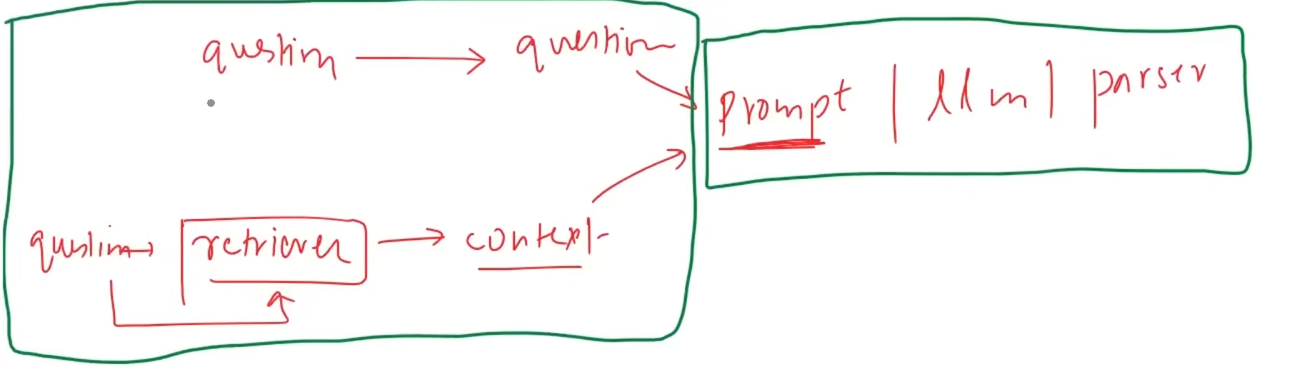

In [22]:
from langchain_core.runnables import RunnableParallel,RunnablePassthrough,RunnableSequence,RunnableLambda
from langchain_core.output_parsers import StrOutputParser

In [23]:
def format_docs(docs):
    content='\n\n'.join(doc.page_content for doc in docs)
    return content

In [24]:
parallel_chain=RunnableParallel({
    'question': RunnablePassthrough(),
    'context': retriever|RunnableLambda(format_docs)
})

In [ ]:
parser=StrOutputParser()
main_chain=parallel_chain|prompt|llm|parser

In [ ]:
result=main_chain.invoke('Please summarize the video')
print(result)

### How to improve this simple RAG system?

1. UI based enhancements
2. Evaluation
- Ragas
- LangSmith

3. Indexing
- Document Ingestion

- Text Splitting

- Vector Store (Cloud Based)

4. Retrieval
- Pre-Retrieval

i. Query rewriting using LLM

ii. Multi-query generation

iii. Domain aware routing

- During Retrieval

i. MMR (Maximum Marginal Relevance)

ii. Hybrid Retrieval

iii. Reranking

- Post-Retrieval

i. Contextual Compression


5. Augmentation
- Prompt Templating

- Answer grounding

- Context window optimization

6. Generation
- Answer with Citation

- Guard railing

7. System Design
- Multimodal

- Agentic

- Memory based